In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import thread_the_needle as ttn


from vi_ppo.actor_critic import ActorCritic
from vi_ppo.nets.mlp import Mlp
from vi_ppo.nets.cnn import Cnn
from vi_ppo.modules import ThreadTheNeedleModule
from vi_ppo.dvae import DiscreteVae
import lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Initialise the environment
env = ttn.make("thread_the_needle")

# make the actor critic model
d = env.observation_space.shape
n_a = env.action_space.n
hidden_dims = 16


print("Observation space: ", d) 
print("Action space: ", n_a)

Observation space:  (1, 64, 64)
Action space:  4


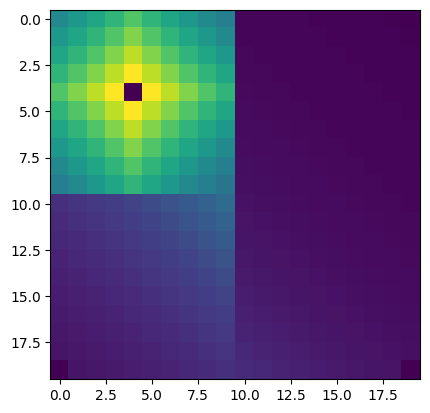

In [3]:
plt.imshow(env.state_values[:-1].reshape(20,20))

In [4]:
env.reset()
env.step(0)

(array([[[ 2,  2,  3, ..., 24, 22, 20],
         [ 2,  3,  3, ..., 25, 23, 21],
         [ 2,  3,  3, ..., 27, 24, 22],
         ...,
         [ 0,  0,  0, ..., 11, 11, 11],
         [ 0,  0,  0, ..., 10, 10, 10],
         [ 0,  0,  0, ...,  9,  9,  9]]], shape=(1, 64, 64)),
 -0.1,
 False,
 False,
 {'start_state': 113,
  'successor_state': 93,
  'state_values': -0.7952065577063574})

In [5]:
# Use a CNN to extract features from the image
feature_extractor_config = Cnn.config_cls(
    input_channels=1, 
    channels=[8,16,1], 
    kernel_sizes=[8,4,1], 
    strides=[2,2,1], 
    padding=[0,0,0],
    flatten_output=True,
    activation="silu",
    )
feature_extractor = Cnn(feature_extractor_config)
embedding_dims = feature_extractor.calculate_output_shape(input_shape=(1,64,64))[1]
print("Number of embeddind dimensions: {embedding_dims}")

# Construct the state inference model
z_dim = 8
z_layers = 4
encoder_config = Mlp.config_cls(
    input_dims=embedding_dims, 
    output_dims=z_dim * z_layers, 
    hidden_dims=embedding_dims, 
    n_layers=1, 
    )
decoder_config = Mlp.config_cls(
    input_dims=z_layers * z_dim, 
    output_dims=embedding_dims, 
    hidden_dims=embedding_dims, 
    n_layers=1, 
    )
vae_config  = DiscreteVae.config_cls(
    z_dim=z_dim, 
    z_layers=z_layers, 
    tau=1e-2, 
    beta=1.
    )
vae = DiscreteVae(
    vae_config,
    encoder=Mlp(encoder_config), 
    decoder=Mlp(decoder_config)
    )


actor_config = Mlp.config_cls(
    input_dims=embedding_dims, 
    output_dims=n_a, 
    hidden_dims=hidden_dims,
    n_layers=1, 
)
critic_config = Mlp.config_cls(
    input_dims=embedding_dims, 
    output_dims=1, 
    hidden_dims=hidden_dims, 
    n_layers=1, 
)
ac_config = ActorCritic.config_cls(
    clip_epsilon=0.2, 
    value_coeff=0.5, 
    entropy_coeff=0.01
)

model = ActorCritic(
    ac_config, 
    actor_net=Mlp(actor_config), 
    critic=Mlp(critic_config), 
    feature_extractor=feature_extractor,
    state_vae = vae,
    )


# module

Number of embeddind dimensions: {embedding_dims}


In [11]:

config = ThreadTheNeedleModule.config_class(lr=3e-4)
module = ThreadTheNeedleModule(actor_critic=model, env=env, config=config)

logger = TensorBoardLogger("../lightning_logs", name="thread_the_needle/notebook")
trainer = pl.Trainer(max_epochs=20, logger=logger)

trainer.fit(module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type        | Params | Mode 
-----------------------------------------------------
0 | actor_critic | ActorCritic | 77.1 K | train
-----------------------------------------------------
77.1 K    Trainable params
0         Non-trainable params
77.1 K    Total params
0.309     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


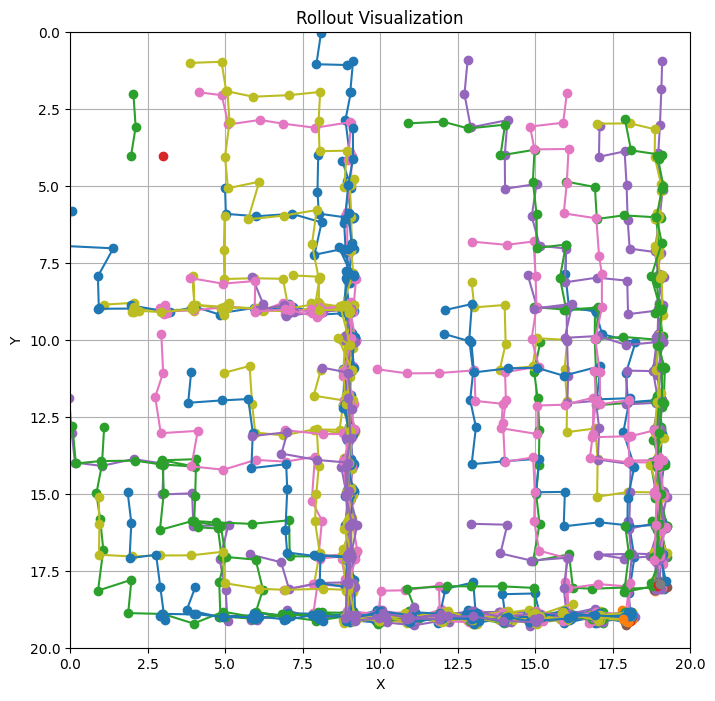

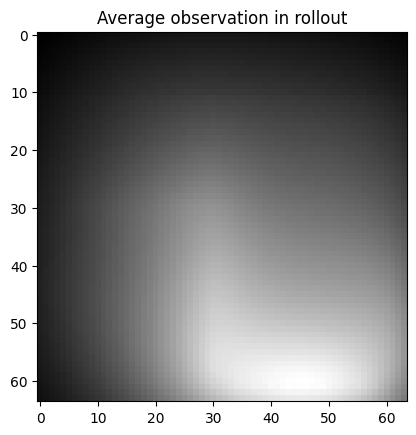

In [12]:
from vi_ppo.utils.plotting import visualize_rollout
visualize_rollout(env, module.buffer)

In [17]:
np.sum(module.buffer.terminated)

np.int64(57)

In [18]:
np.sum(module.buffer.truncated)

np.int64(0)

In [19]:
np.sum(module.buffer.rewards)

np.float64(-245.10000000000005)

In [20]:
env.end_state

[84, 399, 19, 380]

In [22]:
from vi_ppo.utils.vae import estimate_graph_laplacian
laplacian = estimate_graph_laplacian(module.actor_critic, module.buffer, normalized=False)
plt.imshow(laplacian)

IndexError: index 2560 is out of bounds for dimension 0 with size 2560

In [ ]:
laplacian.sum(axis=1).sum()

In [ ]:
import networkx as nx

# convert the laplacian into a graph
laplacian = estimate_graph_laplacian(module.actor_critic, module.buffer, normalized=True)

edges = np.argwhere(laplacian.numpy())
edges = [(i, j) for i, j in edges if i != j]  # remove self-edges

G = nx.Graph()
G.add_edges_from(edges)
nx.draw_networkx(G, with_labels=False, node_size=5)